# 1. Loading Data

In [25]:
import sys
import gc
import os
import warnings
import pickle
import statsmodels.api as sm
from pylab import rcParams
import time

import pandas as pd
from pandas.plotting import register_matplotlib_converters
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import lightgbm as lgb
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import LabelEncoder
from sklearn import preprocessing, metrics

warnings.filterwarnings("ignore")

pd.set_option("display.max_columns", 500)
pd.set_option("display.max_rows", 500)

register_matplotlib_converters()
sns.set()

Reduced= True

## 1.1 Functions

In [26]:
def print_size_var():
    print("Size of Variables")
    _vars = globals().items()
    for var, obj in _vars:
        print(var, sys.getsizeof(obj))
    
def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2    
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)    
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df


def display_missing(df):    
    for col in df.columns.tolist():  
        if df[col].isnull().sum() != 0:
            print('{} column missing values: {}'.format(col, df[col].isnull().sum()))
    print('\n')
    
def encode_categorical(df, cols):
    for col in cols:
        # Leave NaN as it is.
        le = LabelEncoder()
        not_null = df[col][df[col].notnull()]
        df[col] = pd.Series(le.fit_transform(not_null)+1, index=not_null.index)

    return df    

## 1.2 Loading data grid

In [27]:
print('Loading the data...')
DATA_GRID_INPUT_DIR = '.'

data = pd.read_pickle(f'{DATA_GRID_INPUT_DIR}/m5_data.pkl')

Loading the data...


## 1.3 Cuting the dataset

In [28]:
data.head()

,id,item_id,dept_id,cat_id,store_id,state_id,d,demand,part,date,wm_yr_wk,weekday,wday,month,year,event_name_1,event_type_1,event_name_2,event_type_2,sell_price,snap,woy,fyear,week_of_total,is_weekend
7,HOBBIES_1_008_CA_1_validation,1445,4,2,1,1,1,12,train,2011-01-29,11101,Saturday,1,1,2011,NaN,NaN,NaN,NaN,0.459961,0,1,11,1,1
8,HOBBIES_1_009_CA_1_validation,1446,4,2,1,1,1,2,train,2011-01-29,11101,Saturday,1,1,2011,NaN,NaN,NaN,NaN,1.559570,0,1,11,1,1
9,HOBBIES_1_010_CA_1_validation,1447,4,2,1,1,1,0,train,2011-01-29,11101,Saturday,1,1,2011,NaN,NaN,NaN,NaN,3.169922,0,1,11,1,1
11,HOBBIES_1_012_CA_1_validation,1449,4,2,1,1,1,0,train,2011-01-29,11101,Saturday,1,1,2011,NaN,NaN,NaN,NaN,5.980469,0,1,11,1,1
14,HOBBIES_1_015_CA_1_validation,1452,4,2,1,1,1,4,train,2011-01-29,11101,Saturday,1,1,2011,NaN,NaN,NaN,NaN,0.700195,0,1,11,1,1


In [29]:
# Have added little more than a year to our dataset so train data will start 
# at the same period that starts validation, so we will have more
# observations on the validation period
# Training starts at 2013-03-01

data = data.loc[data['date'] >= '2012-09-01'] # So we will have space for lag and rolling features

# 2. Feature Engineering

## Add Item column:


In [30]:
data['items']=round(data['demand']/ data['sell_price'])

77% of daily item sales are zero :



In [31]:
data.loc[data['items']==0, :].shape[0] / data.shape[0]

0.7788336144139372

## Add rolling and lagged features

In [32]:
SHIFT_DAYS = 28

print('Adding demand lag and rolling features')

for val in [28, 29, 30, 31, 32, 33, 34, 35]:
        data[f"lag_t{val}"] = data.groupby(["id"])["demand"].transform(lambda x: x.shift(val)).astype(np.float16)

for val in [7, 14, 30, 60, 180]:
        data[f"rolling_mean_t{val}"] = data.groupby(["id"])["demand"].transform(lambda x: x.shift(SHIFT_DAYS).rolling(val).mean()).astype(np.float16)
        data[f"rolling_std_t{val}"] = data.groupby(["id"])["demand"].transform(lambda x: x.shift(SHIFT_DAYS).rolling(val).std()).astype(np.float16)        
        data[f"rolling_max_t{val}"] = data.groupby(["id"])["demand"].transform(lambda x: x.shift(SHIFT_DAYS).rolling(val).max()).astype(np.float16)
        


Adding demand lag and rolling features


## Adding price related features

In [33]:
data['price_max'] = data.groupby(['store_id','item_id'])['sell_price'].transform('max').astype(np.float16)
data['price_min'] = data.groupby(['store_id','item_id'])['sell_price'].transform('min').astype(np.float16)
data['price_std'] = data.groupby(['store_id','item_id'])['sell_price'].transform('std').astype(np.float16)
data['price_mean'] = data.groupby(['store_id','item_id'])['sell_price'].transform('mean').astype(np.float16)

data["rolling_price_mean_t42"] = data.groupby(["id"])["sell_price"].transform(lambda x: x.rolling(42).mean()).astype(np.float16)
data['price_momentum_t42'] = data['sell_price'] / data['rolling_price_mean_t42']



## Reduce mem usage of created features

In [34]:
data = reduce_mem_usage(data)

Mem. usage decreased to 3827.95 Mb (1.8% reduction)


# 3. Fit & Predict

In [35]:
print('Data usage: {} GB'.format(data.memory_usage(deep=True).sum() / 10**9))
data.head()

Data usage: 4.016267056 GB


,id,item_id,dept_id,cat_id,store_id,state_id,d,demand,part,date,wm_yr_wk,weekday,wday,month,year,event_name_1,event_type_1,event_name_2,event_type_2,sell_price,snap,woy,fyear,week_of_total,is_weekend,items,lag_t28,lag_t29,lag_t30,lag_t31,lag_t32,lag_t33,lag_t34,lag_t35,rolling_mean_t7,rolling_std_t7,rolling_max_t7,rolling_mean_t14,rolling_std_t14,rolling_max_t14,rolling_mean_t30,rolling_std_t30,rolling_max_t30,rolling_mean_t60,rolling_std_t60,rolling_max_t60,rolling_mean_t180,rolling_std_t180,rolling_max_t180,price_max,price_min,price_std,price_mean,rolling_price_mean_t42,price_momentum_t42
17714691,HOBBIES_1_002_CA_1_validation,1439,4,2,1,1,582,3,train,2012-09-01,11232,Saturday,1,9,2012,NaN,NaN,NaN,NaN,3.970703,1,32,12,84,1,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.970703,3.970703,0.000000,3.970703,NaN,NaN
17714693,HOBBIES_1_004_CA_1_validation,1441,4,2,1,1,582,1,train,2012-09-01,11232,Saturday,1,9,2012,NaN,NaN,NaN,NaN,4.339844,1,32,12,84,1,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.640625,4.339844,0.100708,4.601562,NaN,NaN
17714694,HOBBIES_1_005_CA_1_validation,1442,4,2,1,1,582,2,train,2012-09-01,11232,Saturday,1,9,2012,NaN,NaN,NaN,NaN,2.980469,1,32,12,84,1,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.080078,2.880859,0.096680,2.976562,NaN,NaN
17714695,HOBBIES_1_006_CA_1_validation,1443,4,2,1,1,582,0,train,2012-09-01,11232,Saturday,1,9,2012,NaN,NaN,NaN,NaN,1.000000,1,32,12,84,1,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.000000,0.959961,0.017548,0.989746,NaN,NaN
17714696,HOBBIES_1_007_CA_1_validation,1444,4,2,1,1,582,0,train,2012-09-01,11232,Saturday,1,9,2012,NaN,NaN,NaN,NaN,7.941406,1,32,12,84,1,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7.941406,7.878906,0.013817,7.882812,NaN,NaN


In [36]:
# data.columns
features = ["item_id", "dept_id", "cat_id", "store_id", "state_id",\
            "snap", "sell_price", \
    # time features.
            "fyear", "month", "wday","woy",  'week_of_total', \
    # event-related features # Commented because I have accidently skipped them while building the kernel,
    #                        also they show no feature importance, may be we can process them in a different way
    #        'Pesach End', 'OrthodoxEaster', 'Cinco De Mayo', "Mother's day", \
      'event_name_1', 'event_type_1', 'event_name_2', 'event_type_2',\
    # price-related
      'price_min', 'price_max', 'price_std', 'price_mean', 'price_momentum_t42', \
    # product-related features
#             'demand_active', \
    # lags and rollings on demand -related features 
           'lag_t28', 'lag_t29', 'lag_t30', 'lag_t31', 'lag_t32', 'lag_t33', 'lag_t34', 'lag_t35', \
            'rolling_mean_t7', 'rolling_mean_t14', 'rolling_mean_t30', 'rolling_mean_t60', 'rolling_mean_t180', \
            'rolling_std_t7', 'rolling_std_t14', 'rolling_std_t30', 'rolling_std_t60', 'rolling_std_t180', \
            'rolling_max_t7', 'rolling_max_t14', 'rolling_max_t30', 'rolling_max_t60', 'rolling_max_t180', \
    # Predicted features
            'id', 'date', 'demand']

# + rolling_means/std, price change, rolling_price, ...

cat_features = ['item_id', 'dept_id','store_id', 'cat_id', 'state_id'] + \
               ["event_name_1", "event_name_2", "event_type_1", "event_type_2"] # To pass to lgbm



## Loading weights for WRMSSE from pickle

In [37]:
WEIGHTS_INPUT_DIR = '.'

with open(f'{WEIGHTS_INPUT_DIR}/weight1.pkl', 'rb') as f:
    weight1 = pickle.load(f)
    
with open(f'{WEIGHTS_INPUT_DIR}/weight2.pkl', 'rb') as f:
    weight2 = pickle.load(f)
    
with open(f'{WEIGHTS_INPUT_DIR}/weight_mat_csr.pkl', 'rb') as f:
    weight_mat_csr = pickle.load(f)


In [38]:
def wrmsse(preds, data):
    
    # this function is calculate for last 28 days to consider the non-zero demand period
    
    # actual obserbed values 
    y_true = data.get_label()
    
    y_true = y_true[-(30490 * 28):]
    preds = preds[-(30490 * 28):]
    # number of columns
    num_col = 28
    
    # reshape data to original array((30490*num_col,1)->(30490, num_col) ) 
    reshaped_preds = preds.reshape(num_col, 30490).T
    reshaped_true = y_true.reshape(num_col, 30490).T
    
          
    train = weight_mat_csr*np.c_[reshaped_preds, reshaped_true]
    
    score = np.sum(
                np.sqrt(
                    np.mean(
                        np.square(
                            train[:,:num_col] - train[:,num_col:])
                        ,axis=1) / weight1) * weight2)
    
    return 'wrmsse', score, False

In [39]:
# Date limitation to 2014 and after (for now)
x_train = data[(data['date'] <= '2016-03-27') & (data['date'] >= '2013-03-01')][features]
y_train = data[(data['date'] <= '2016-03-27') & (data['date'] >= '2013-03-01')]['demand']
x_val = data[(data['date'] > '2016-03-27') & (data['date'] <= '2016-04-24')][features]
y_val = data[(data['date'] > '2016-03-27') & (data['date'] <= '2016-04-24')]['demand']
x_test = data[(data['date'] > '2016-04-24')][features]
del data
gc.collect()

0

In [40]:
params = {
        'metric': 'rmse',
        'objective': 'poisson',
        "force_row_wise" : True,
        "learning_rate" : 0.075,
        "sub_row" : 0.75,
        "bagging_freq" : 1,
        "lambda_l2" : 0.1,
        'n_jobs': -1,
        'verbosity': 1,
        'num_iterations' : 1500
        }

train_set = lgb.Dataset(x_train.drop(['id', 'date', 'demand'], axis = 1), y_train, categorical_feature = cat_features)
val_set = lgb.Dataset(x_val.drop(['id', 'date', 'demand'], axis = 1), y_val, categorical_feature = cat_features)
del x_train, y_train
gc.collect()

20

In [41]:
reduce_mem_usage(x_val)
reduce_mem_usage(x_test)
gc.collect()

Mem. usage decreased to 78.83 Mb (0.0% reduction)
Mem. usage decreased to 78.02 Mb (1.0% reduction)


0

In [42]:
lgb_model = lgb.train(params, train_set, early_stopping_rounds = 125, valid_sets = [train_set, val_set],
    verbose_eval = 50)

Training until validation scores don't improve for 125 rounds
[50]	training's rmse: 2.70814	valid_1's rmse: 2.27541
[100]	training's rmse: 2.6507	valid_1's rmse: 2.22824
[150]	training's rmse: 2.57743	valid_1's rmse: 2.21949
[200]	training's rmse: 2.52559	valid_1's rmse: 2.21335
[250]	training's rmse: 2.49886	valid_1's rmse: 2.20457
[300]	training's rmse: 2.47822	valid_1's rmse: 2.19722
[350]	training's rmse: 2.45891	valid_1's rmse: 2.19182
[400]	training's rmse: 2.4414	valid_1's rmse: 2.18514
[450]	training's rmse: 2.4245	valid_1's rmse: 2.17722
[500]	training's rmse: 2.40983	valid_1's rmse: 2.16897
[550]	training's rmse: 2.39741	valid_1's rmse: 2.16219
[600]	training's rmse: 2.38664	valid_1's rmse: 2.15831
[650]	training's rmse: 2.37586	valid_1's rmse: 2.15379
[700]	training's rmse: 2.36633	valid_1's rmse: 2.15091
[750]	training's rmse: 2.35796	valid_1's rmse: 2.14905
[800]	training's rmse: 2.34952	valid_1's rmse: 2.14895
[850]	training's rmse: 2.34208	valid_1's rmse: 2.15259
[900]	t

In [43]:
# Commented out to re
# list1 = [ele for ele in features if ele not in ('id', 'date', 'demand')] 
# val_pred = lgb_model.predict(x_val[list1], num_iteration=lgb_model.best_iteration)
# val_score = np.sqrt(mean_squared_error(val_pred, y_val))
# print(f'Our val rmse score is {val_score}')
y_pred = lgb_model.predict(x_test[list1], num_iteration=lgb_model.best_iteration)
x_test['demand'] = y_pred
predictions = x_test[['id', 'date', 'demand']]
predictions = pd.pivot(predictions, index = 'id', columns = 'date', values = 'demand').reset_index()
predictions.columns = ['id'] + ['F' + str(i + 1) for i in range(28)]

INPUT_DIR = 'data'
sample_submission = pd.read_csv(f'{INPUT_DIR}/sample_submission.csv')
    
evaluation_rows = [row for row in sample_submission['id'] if 'evaluation' in row] 
evaluation = sample_submission[sample_submission['id'].isin(evaluation_rows)]

validation = sample_submission[['id']].merge(predictions, on = 'id')

final = pd.concat([validation, evaluation])
final.to_csv('sample_submission.csv', index = False)

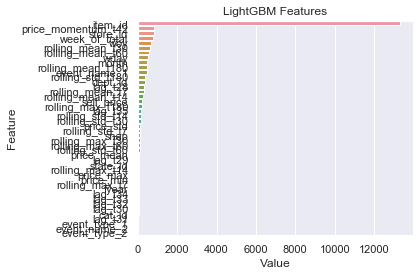

In [52]:
feature_importance = pd.DataFrame({"Value": lgb_model.feature_importance(), "Feature": lgb_model.feature_name()}) \
                    .sort_values(by="Value", ascending=False)

sns.barplot(x="Value", y="Feature", data=feature_importance)
plt.title('LightGBM Features')
plt.tight_layout()
plt.show()

In [53]:
# Detection of features with zero-importance
# zero_features = list(feature_importance[feature_importance['Value'] == 0]['Feature'])
# print('\nThere are {} features with 0.0 importance'.format(len(zero_features)))
# print(zero_features)
feature_importance

,Value,Feature
0,13329,item_id
20,817,price_momentum_t42
3,800,store_id
11,777,week_of_total
10,691,woy
31,630,rolling_mean_t30
32,561,rolling_mean_t60
9,529,wday
8,462,month
33,458,rolling_mean_t180


In [54]:
final = pd.concat([validation, evaluation])

for i in range(1,29):
    final['F'+str(i)] *= 1.03
    
final.to_csv('submission3.csv', index=False) 